In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import momepy

/opt/miniconda3/envs/book/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Convert shapefile to graph
hghway = gpd.read_file("/Users/jr555/Downloads/tl_2023_37_prisecroads/tl_2023_37_prisecroads.shp")
hghway = hghway.to_crs('EPSG:32617')
graph = momepy.gdf_to_nx(hghway, approach="primal", directed=True)

DataSourceError: /Users/jr555/Downloads/tl_2023_37_prisecroads/tl_2023_37_prisecroads.shp: No such file or directory

In [76]:
# Convert graph to gdf
nodes, edges = momepy.nx_to_gdf(graph)

In [77]:
# Provide an x and y for OSMnx
nodes['x'] = nodes['geometry'].x
nodes['y'] = nodes['geometry'].y

In [78]:
# Provide a u and v for OSMnx
edges['u'] = edges['node_start']
edges['v'] = edges['node_end']

In [79]:
# Make all roads "two-way"
opposite_direction = edges.copy()
opposite_direction = opposite_direction.rename(columns={"u": "v", "v": "u"})
directed_edges = pd.concat([edges, opposite_direction], ignore_index=True)

In [80]:
# Create a new unique key for each (u, v) pair
edges = directed_edges
edges['key'] = edges.groupby(['u', 'v']).cumcount()

# Set the MultiIndex back
edges = edges.set_index(['u', 'v', 'key']).sort_index()

In [81]:
# Convery back to graph
gdf = ox.graph_from_gdfs(nodes, edges)

In [82]:
# Save and load
ox.save_graphml(gdf, '/Users/jr555/Downloads/tl_2023_37_prisecroads/graph.graphml')
graph = ox.load_graphml('/Users/jr555/Downloads/tl_2023_37_prisecroads/graph.graphml')

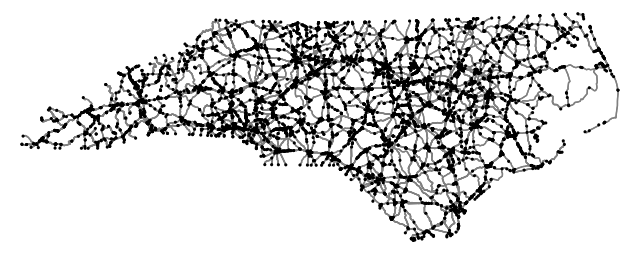

In [83]:
# Plot
fig, ax = ox.plot_graph(graph, bgcolor='white', node_color='black', edge_color='grey', node_size=5)